# Explore options for a simple exploitation of the Gaia DR3 OBA star golden sample.

These were the preliminary explorations of the OBA young disk star sample the paper _Gaia Data Release 3: A Golden Sample of Astrophysical Parameters_ by [Gaia Collaboration, Creevey et al. (2022)](). This led to the modelling of the Milky Way rotation curve described in section 10.1 of that paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Wedge
from matplotlib import cm, rc
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import re
import cartopy.crs as ccrs
import healpy as hp
from astropy.table import Table
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
from astropy.visualization import HistEqStretch, ImageNormalize, SinhStretch, AsinhStretch
import astropy.units as u
import astropy.constants as c
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from astroML.plotting.mcmc import convert_to_stdev
from scipy.special import erf

from agabpylib.plotting.plotstyles import useagab, apply_tufte
from icrstogal import *

from gala.potential.potential.builtin.special import BovyMWPotential2014
from diskkinematicmodel import *

useagab(axislinewidths=2, linewidths=3)

## Kinematic disk model

Create a very simple kinematic model of the disk in which all stars are on circular orbits with speeds $V_\phi(R)$ given by the rotation curve extracted from the selected potential. See [diskkinematicmodel.py](diskkinematicmodel.py). Also define here the limits in total and tangential velocity for separating thin disk, thick disk, and halo populations.

* Thin disk: $v_\mathrm{tot}<50$ km s$^{-1}$, $v_\mathrm{tan}<40$ km s$^{-1}$
* Thick disk: $50\leq v_\mathrm{tot}\leq180$ km s$^{-1}$, $40\leq v_\mathrm{tan}\leq 180$ km s$^{-1}$
* Halo: $v_\mathrm{tot}>180$ km s$^{-1}$, $v_\mathrm{tan}>180$ km s$^{-1}$

In [2]:
Rsun = 8277.0*u.pc
zsun = 20.8*u.pc
sunpos = np.array([-Rsun.value, 0, zsun.value])*u.pc
sun_u = 11.1
sun_v = 12.24
sun_w = 7.25
vsunpeculiar = np.array([sun_u,sun_v,sun_w])*u.km/u.s

diskmodel = DiskKinematicModel(BovyMWPotential2014(), sunpos, vsunpeculiar)
diskmodel_alt = DiskKinematicModel(FlatRotationCurve(225.0), sunpos, np.array([9.0, 13.0, 8.0])*u.km/u.s)

vcircsun = diskmodel.get_circular_velocity(sunpos)[0]
print(vcircsun)

vtanthin = 40.0
vtanhalo = 180.0
vtotthin = 50.0
vtothalo = 180.0

plxsnr_min = 10

219.22899730786094 km / s


# Source table meta-data and definition of sub-samples

Read in the data, calculate the value of the tangential velocity, and the galactic coordinates and galactic proper motions. The tangential velocity is:

\begin{equation}
v_\mathrm{tan} = \frac{A_\mathrm{v}}{\varpi}\sqrt{\mu_{\alpha*}^2+\mu_\delta^2}
\end{equation}

In [6]:
obatable = Table.read('../data/OBAGoldenSample.fits', format='fits')
obatable['parallax_over_error'] = obatable['parallax']/obatable['parallax_error']
obatable['vtan'] = (au_km_year_per_sec/obatable['parallax']*np.sqrt(obatable['pmra']**2+obatable['pmdec']**2)).value*u.km/u.s
icrs_coords = ICRS(ra = (obatable['ra'].data*u.deg).to(u.rad),
                   dec = (obatable['dec'].data*u.deg).to(u.rad),
                   distance = (1000/obatable['parallax'].data)*u.pc,
                   pm_ra_cosdec = obatable['pmra'].data*u.mas/u.yr,
                   pm_dec = obatable['pmdec'].data*u.mas/u.yr,
                  radial_velocity = obatable['ra'].value*0.0*u.km/u.s)

galactic_coords, galactocentric_cartesian, galactocentric_cylindrical = transform_to_galactic(icrs_coords, galcendist=Rsun, sunheight=zsun, vcircsun=vcircsun, 
        vsunpec=vsunpeculiar)

obatable['l'] = galactic_coords.l.to(u.deg)
obatable['b'] = galactic_coords.b.to(u.deg)
obatable['pml'] = galactic_coords.pm_l_cosb
obatable['pmb'] = galactic_coords.pm_b

obatable['x_gc'] = galactocentric_cartesian.x
obatable['y_gc'] = galactocentric_cartesian.y
obatable['z_gc'] = galactocentric_cartesian.z
obatable['R_gc'] = galactocentric_cylindrical.rho

obatable['gmag0_gspphot'] = obatable['phot_g_mean_mag'] - obatable['ag_gspphot']
obatable['gmag0_esphs'] = obatable['phot_g_mean_mag'] - obatable['ag_esphs']
obatable['bp_rp0_gspphot'] = obatable['bp_rp'] - obatable['ebpminrp_gspphot']
obatable['bp_rp0_esphs'] = obatable['bp_rp'] - obatable['ebpminrp_esphs']

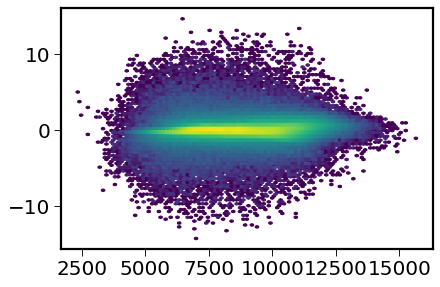

In [7]:
plxfilter = obatable['parallax_over_error'] > 10
d = (1000/obatable['parallax']*np.cos(np.deg2rad(obatable['b'])))[plxfilter]
cosl = np.cos(np.deg2rad(obatable['l'][plxfilter]))
Ralt = np.sqrt(d*d+Rsun.value**2-2*Rsun.value*d*cosl)

plt.hexbin(obatable['R_gc'][plxfilter], Ralt-obatable['R_gc'][plxfilter], bins='log', mincnt=1)

Define some sub-samples (O, B, A stars).

In [8]:
ostars = (obatable['spectraltype_esphs'] == 'O')
bstars = (obatable['spectraltype_esphs'] == 'B')
astars = (obatable['spectraltype_esphs'] == 'A')
num_esp_ostars = obatable['source_id'][ostars].size
num_esp_bstars = obatable['source_id'][bstars].size
num_esp_astars = obatable['source_id'][astars].size
print(f"Number of ESPHS classified O stars: {num_esp_ostars}")
print(f"Number of ESPHS classified B stars: {num_esp_bstars}")
print(f"Number of ESPHS classified A stars: {num_esp_astars}")
print(f"Total ESPHS classified OBA stars: {num_esp_ostars+num_esp_bstars+num_esp_astars}")
print()

rvvalid = np.logical_not(np.isnan(obatable['radial_velocity']))
print(f"Number of OBA stars with RV: {obatable['source_id'][rvvalid].size}")
print(f"Number of ESPHS classified O stars with RV: {obatable['source_id'][ostars & rvvalid].size}")
print(f"Number of ESPHS classified B stars with RV: {obatable['source_id'][bstars & rvvalid].size}")
print(f"Number of ESPHS classified A stars with RV: {obatable['source_id'][astars & rvvalid].size}")
print(f"Total ESPHS classified OBA stars with RV: {obatable['source_id'][(ostars | bstars | astars) & rvvalid].size}")

Number of ESPHS classified O stars: 7903
Number of ESPHS classified B stars: 682199
Number of ESPHS classified A stars: 2056891
Total ESPHS classified OBA stars: 2746993

Number of OBA stars with RV: 439522
Number of ESPHS classified O stars with RV: 1313
Number of ESPHS classified B stars with RV: 99320
Number of ESPHS classified A stars with RV: 283214
Total ESPHS classified OBA stars with RV: 383847


## Calculate the 6D phase space coordinates for the stars with a radial velocity

This refers to 3D galactocentric position and velocities of the stars in both Cartesian and Cylindrical coordinates. This can only be done for stars with radial velocities. From these data also the total velocity with the respect to the local circular velocity (or local standard of rest, LSR) is calculated as:

\begin{equation}
    v_\mathrm{tot,LSR} = \sqrt{v_R^2+v_z^2+(v_\phi-v_\mathrm{LSR})^2}\,,
\end{equation}

where $v_\mathrm{LSR}$ is taken from the disk kinematic model selected above.

In [9]:
oba_rv = obatable[:][rvvalid]
icrs_coords = ICRS(ra = (oba_rv['ra'].data*u.deg).to(u.rad),
                   dec = (oba_rv['dec'].data*u.deg).to(u.rad),
                   distance = (1000/oba_rv['parallax'].data)*u.pc,
                   pm_ra_cosdec = oba_rv['pmra'].data*u.mas/u.yr,
                   pm_dec = oba_rv['pmdec'].data*u.mas/u.yr,
                   radial_velocity = oba_rv['radial_velocity'].data*u.km/u.s)

galactic_coords, galactocentric_cartesian, galactocentric_cylindrical = transform_to_galactic(icrs_coords, galcendist=Rsun, sunheight=zsun, vcircsun=vcircsun, 
        vsunpec=vsunpeculiar)

oba_rv['l'] = galactic_coords.l.to(u.deg)
oba_rv['b'] = galactic_coords.b.to(u.deg)
oba_rv['pml'] = galactic_coords.pm_l_cosb
oba_rv['pmb'] = galactic_coords.pm_b

oba_rv['x_gc'] = galactocentric_cartesian.x
oba_rv['y_gc'] = galactocentric_cartesian.y
oba_rv['z_gc'] = galactocentric_cartesian.z
oba_rv['v_x_gc'] = galactocentric_cartesian.v_x
oba_rv['v_y_gc'] = galactocentric_cartesian.v_y
oba_rv['v_z_gc'] = galactocentric_cartesian.v_z

#Convert Cylindrical into conventional units (km/s for the velocities, making v_phi positive along
#the direction of Galactic rotation).
oba_rv['R_gc'] = galactocentric_cylindrical.rho
phi = galactocentric_cylindrical.phi.to(u.deg)
oba_rv['phi_gc'] = np.where(phi<0*u.deg, phi+360*u.deg, phi.to(u.deg))*u.deg
oba_rv['v_R_gc'] = galactocentric_cylindrical.d_rho.to(u.km/u.s)
# In the literature vphi is calculated for a left-handed coordinate system! 
# This is for the convenience of having postive values of vphi at the position of the sun.
oba_rv['v_phi_gc'] = -(galactocentric_cylindrical.d_phi.to(u.rad/u.yr)/u.rad * galactocentric_cylindrical.rho).to(u.km/u.s)

oba_rv['vtot_lsr'] = np.sqrt(oba_rv['v_R_gc']**2 + (oba_rv['v_phi_gc']-vcircsun.value)**2 + oba_rv['v_z_gc']**2)

ostars_rv = (oba_rv['spectraltype_esphs'] == 'O')
bstars_rv = (oba_rv['spectraltype_esphs'] == 'B')
astars_rv = (oba_rv['spectraltype_esphs'] == 'A')

## Proper motions vs galactic coordinates

Plot $\mu_{\ell*}$ and $\mu_b$ vs. galactic longitude and overplot lines of predicted proper motions at fixed distances $d$ from the Sun for stars located at $z=0$. This means these stars are seen at a latitude of $b = -\arcsin(z_\odot/d)$.

The shapes of the lines are sensitive to these model parameters:
* sun's peculiar motion
* distance
* height of the sun above (or below) the galactic plane
* rotation curve

1000/plx_median = 2304 pc


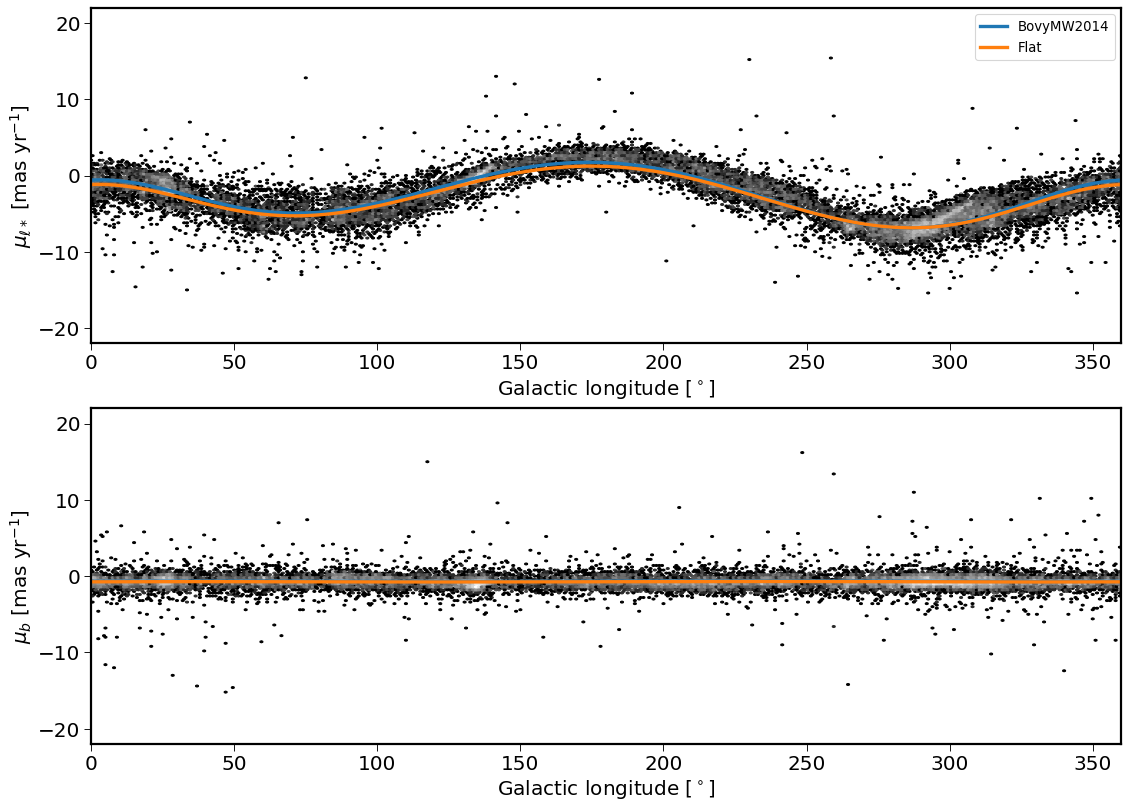

In [10]:
galon = np.linspace(0,360,361)*u.deg

plxsnr_lim = plxsnr_min
plxfilter = obatable['parallax_over_error']>plxsnr_lim
plxfilter_rv = oba_rv['parallax_over_error']>plxsnr_lim
nonhalo = obatable['vtan'] < vtanhalo
zmax = 1000000

sample_filter_init = bstars & plxfilter & nonhalo & (np.abs(obatable['z_gc']) < zmax)

median_dist = 1000/np.median(obatable['parallax'][sample_filter_init])
dmax = median_dist+100
dmin = median_dist-100
dist_filter = (obatable['parallax'] > 1000/dmax) & (obatable['parallax'] < 1000/dmin)

R_filter = (obatable['R_gc']>6900) & (obatable['R_gc']<7100)

sample_filter = sample_filter_init & dist_filter

print(f"1000/plx_median = {median_dist:.0f} pc")

fig=plt.figure(constrained_layout=True, figsize=(14,10))

gs = GridSpec(2, 1, figure=fig)

ax_lmul = fig.add_subplot(gs[0,0])
im_lmul = ax_lmul.hexbin(obatable['l'][sample_filter], obatable['pml'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20], cmap='Greys_r')
ax_lmul.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmul.set_ylabel(r'$\mu_{\ell*}$ [mas yr$^{-1}$]')
ax_lmul.set_xlim(0,360)

ax_lmub = fig.add_subplot(gs[1,0])
im_lmub = ax_lmub.hexbin(obatable['l'][sample_filter], obatable['pmb'][sample_filter], 
                         gridsize=[360,100], mincnt=1, bins='log', extent=[0,360,-20,20], cmap='Greys_r')
ax_lmub.set_xlabel(r'Galactic longitude [$^\circ$]')
ax_lmub.set_ylabel(r'$\mu_b$ [mas yr$^{-1}$]')
ax_lmub.set_xlim(0,360)

# Vary model distance
#for dist in [median_dist]:
#    distance = np.zeros_like(galon.value) + dist*u.pc
#    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/dist))*u.deg
#    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat)
#    ax_lmul.plot(galon, pml_model, label=rf'$d={dist:.0f}$ pc')
#    ax_lmub.plot(galon, pmb_model)
 
# Vary height of sun
#distance = np.zeros_like(galon.value) + median_dist*u.pc
#for z in [-500, 0, zsun.value, 50, 500]:
#    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(z/median_dist))*u.deg
#    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat, sunpos=np.array([-Rsun.value, 0, z])*u.pc)
#    ax_lmul.plot(galon, pml_model)
#    ax_lmub.plot(galon, pmb_model)

# Compare rotation curve models
distance = np.zeros_like(galon.value) + median_dist*u.pc
galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/median_dist))*u.deg
for model, lab in zip([diskmodel, diskmodel_alt], ['BovyMW2014', 'Flat']):
    pml_model, pmb_model, vrad_model = model.observables(distance, galon, galat)
    ax_lmul.plot(galon, pml_model, label=lab)
    ax_lmub.plot(galon, pmb_model)

# Vary sun's peculiar velocity in Z
#distance = np.zeros_like(galon.value) + median_dist*u.pc
#for vsunz in [-20, 0, sun_w, 20]:
#    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/median_dist))*u.deg
#    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat, vsunpec=np.array([sun_u, sun_v, vsunz])*u.km/u.s)
#    ax_lmul.plot(galon, pml_model, alpha=1)
#    ax_lmub.plot(galon, pmb_model, alpha=1)

# Vary sun's peculiar velocity in X
#distance = np.zeros_like(galon.value) + median_dist*u.pc
#for vsunx in [-20, 0, sun_u, 20]:
#    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/median_dist))*u.deg
#    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat, vsunpec=np.array([vsunx, sun_v, sun_w])*u.km/u.s)
#    ax_lmul.plot(galon, pml_model, alpha=1)
#    ax_lmub.plot(galon, pmb_model, alpha=1)

# Vary sun's peculiar velocity in Y
#distance = np.zeros_like(galon.value) + median_dist*u.pc
#for vsuny in [-20, 0, sun_v, 20]:
#    galat = np.zeros_like(galon.value) - np.rad2deg(np.arcsin(zsun.value/median_dist))*u.deg
#    pml_model, pmb_model, vrad_model = diskmodel.observables(distance, galon, galat, vsunpec=np.array([sun_u, vsuny, sun_w])*u.km/u.s)
#    ax_lmul.plot(galon, pml_model, alpha=1, label=rf'$V_\odot={vsuny}$ km s$^{{-1}}$')
#    ax_lmub.plot(galon, pmb_model, alpha=1)

ax_lmul.legend(fontsize=12)

plt.show()

## Azimuthal velocity vs $R$

__NOTE__ The radial velocity corrections for hot stars recommended by [Blomme et al (2022)]() are not used here.

94284


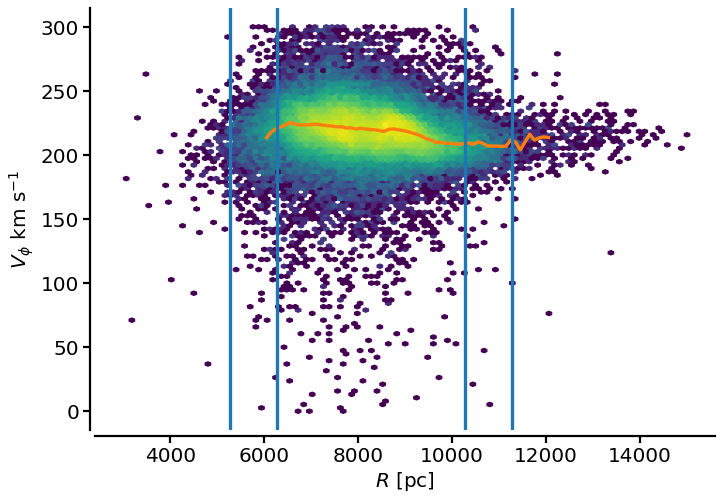

In [11]:
plxfilter = oba_rv['parallax_over_error']>10

rbins = np.linspace(6000, 12000, 61)
digitized = np.digitize(oba_rv['R_gc'][bstars_rv & plxfilter], rbins)
print(digitized.size)
vphi_medians = np.zeros(rbins.size)
for i in range(rbins.size):
    vphi_medians[i] = np.median(oba_rv['v_phi_gc'][bstars_rv & plxfilter][digitized==i])

fig, axvphi = plt.subplots(1, 1, figsize=(10,7))
apply_tufte(axvphi)

axvphi.hexbin(oba_rv['R_gc'][bstars_rv & plxfilter], oba_rv['v_phi_gc'][bstars_rv & plxfilter], bins='log', mincnt=1, extent=[3000,15000,0,300])
axvphi.plot(rbins+50.0, vphi_medians, color='C1')
axvphi.set_xlabel(r'$R$ [pc]')
axvphi.set_ylabel(r'$V_\phi$ km s$^{-1}$')
axvphi.axvline(x=8277-3000)
axvphi.axvline(x=8277-2000)
axvphi.axvline(x=8277+2000)
axvphi.axvline(x=8277+3000)

plt.show()